# Building a scorecard model

This tutorial shows how to build a `skorecard` model.

Start by loading the data and performiing the train test split:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from skorecard.datasets import load_credit_card
from sklearn.model_selection import train_test_split

data = load_credit_card(as_frame=True)


X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['y'], axis=1),
    data['y'], 
    test_size=0.25, 
    random_state=42
)

Load the buckets and the selected features that were created in the previous tutorials.

In [2]:
import yaml
buckets_dict = yaml.safe_load(open("buckets.yml",'r'))
selected_features = ['x6','x8','x10','x18','x1','x19','x20','x21','x23','x22','x3','x17','x16']

### Define the scorecard model

A Skorecard class has two main components:
- the bucketer
- the list of selected features (if None is passed, it uses all the features defined in the bucketer)

It behaves like a scikit-learn model


In [3]:
from skorecard import Skorecard
from skorecard.bucketers import UserInputBucketer

scorecard = Skorecard(
    bucketing=UserInputBucketer(buckets_dict),
    variables=selected_features,
    calculate_stats=True
)
scorecard = scorecard.fit(X_train, y_train)

The `get_stats` method returns the coefficients with their standard error and p-values

In [4]:
scorecard.get_stats()

,Coef.,Std.Err,z,P>|z|
const,-1.241909,0.018234,-68.108318,0.000000e+00
x6,-0.765686,0.020628,-37.118825,1.396362e-301
x8,-0.277082,0.033663,-8.231014,1.856352e-16
x10,-0.323763,0.036347,-8.907520,5.218682e-19
x18,-0.226041,0.050366,-4.488000,7.189489e-06
x1,-0.394552,0.048151,-8.194025,2.526325e-16
x19,-0.165788,0.055869,-2.967422,3.003087e-03
x20,-0.253802,0.062855,-4.037910,5.392951e-05
x21,-0.097436,0.072469,-1.344523,1.787793e-01
x23,-0.176596,0.073965,-2.387563,1.696051e-02


Retrieve the model performance like in any sklearn classifier

In [5]:
from sklearn.metrics import roc_auc_score, classification_report
proba_train = scorecard.predict_proba(X_train)[:,1]
proba_test = scorecard.predict_proba(X_test)[:,1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}\n")

print(classification_report(y_test, scorecard.predict(X_test)))


AUC train:0.7714
AUC test :0.7642

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      5873
           1       0.66      0.34      0.45      1627

    accuracy                           0.82      7500
   macro avg       0.75      0.65      0.67      7500
weighted avg       0.80      0.82      0.80      7500



### Removing features based on their statistical properties

Features can be further removed.<br>
In a scorecard model, the coefficients are expected to be between 0 and -1.<br>
Coefficients smaller than -1 indicate that the model relies heavily on a features (likely to overfit), while positive coefficients show an inveerted trend.

Additionally, p-values of the coefficient should be smaller that 0.05. (or 0.01).

Looking at the stats table above, this would suggest removing the following features from the list `['x21','x16','x17','x22']`.

Note that feature removal should be done carefully, as everytime the feature is removed, the coefficients might converge elsewhere, and hence giving different model with a different interpretation.

In [6]:
new_feats = [feat for feat in selected_features if feat not in ['x21','x16','x17','x22']]

scorecard = Skorecard(
    UserInputBucketer(buckets_dict),
    variables=new_feats,
    calculate_stats=True
)

scorecard = scorecard.fit(X_train, y_train)

model_stats = scorecard.get_stats()

model_stats.index = ['Const'] + new_feats
display(model_stats)

proba_train = scorecard.predict_proba(X_train)[:,1]
proba_test = scorecard.predict_proba(X_test)[:,1]

print(f"AUC train:{round(roc_auc_score(y_train, proba_train),4)}")
print(f"AUC test :{round(roc_auc_score(y_test, proba_test),4)}")

,Coef.,Std.Err,z,P>|z|
Const,-1.241603,0.018225,-68.125518,0.000000e+00
x6,-0.764208,0.020602,-37.094054,3.503284e-301
x8,-0.269190,0.033241,-8.098050,5.584713e-16
x10,-0.339152,0.035175,-9.641740,5.327710e-22
x18,-0.241746,0.049655,-4.868497,1.124502e-06
x1,-0.409005,0.046597,-8.777552,1.670710e-18
x19,-0.191925,0.053792,-3.567929,3.598136e-04
x20,-0.281660,0.060816,-4.631336,3.633141e-06
x23,-0.227582,0.069555,-3.271986,1.067949e-03
x3,-0.440842,0.095443,-4.618917,3.857474e-06


AUC train:0.7713
AUC test :0.7648


### Retrieving the transformed data

Buckets and WoE transformations are available directly in a fitted `skorecard` model

In [7]:
print("Top 5 rows and the transformed buckets")
display(scorecard.bucket_transform(X_test)[new_feats].head())

print("\nTop 5 rows and the transformed WoEs")
display(scorecard.woe_transform(X_test)[new_feats].head())

Top 5 rows and the transformed buckets


,x6,x8,x10,x18,x1,x19,x20,x23,x3
2308,1,0,0,1,0,1,1,1,1
22404,1,0,0,1,2,1,1,2,0
23397,1,0,0,1,0,1,1,2,2
25058,1,0,0,1,1,1,2,2,2
2664,1,0,0,1,-3,1,1,1,1



Top 5 rows and the transformed WoEs


,x6,x8,x10,x18,x1,x19,x20,x23,x3
2308,0.668214,0.321072,0.229952,0.029155,-0.610435,-0.00042,0.015423,-0.105218,-0.102405
22404,0.668214,0.321072,0.229952,0.029155,0.353700,-0.00042,0.015423,0.257127,0.192772
23397,0.668214,0.321072,0.229952,0.029155,-0.610435,-0.00042,0.015423,0.257127,-0.167585
25058,0.668214,0.321072,0.229952,0.029155,-0.069828,-0.00042,0.406017,0.257127,-0.167585
2664,0.668214,0.321072,0.229952,0.029155,-0.223667,-0.00042,0.015423,-0.105218,-0.102405


# Getting the feature importance (to be integrated in the skorecard class)

In order to talk of feature importance, we should consider both the coefficients and the IV of the single feature.
The importance cab be approximated as the product of the two numbers.

In [8]:
from skorecard.reporting import iv

X_train_bins = scorecard.bucket_transform(X_train)
iv_dict = iv(X_train_bins, y_train)

iv_values = pd.Series(iv_dict).sort_values(ascending=False)
iv_values.name="IV"

feat_importance = model_stats[['Coef.']].join(iv_values)
feat_importance['importance'] = -1.*feat_importance['Coef.']*feat_importance['IV']
feat_importance.sort_values(by='importance', ascending=False)

,Coef.,IV,importance
x6,-0.764208,0.881380,0.673558
x8,-0.269190,0.431407,0.116130
x10,-0.339152,0.333630,0.113151
x1,-0.409005,0.175246,0.071677
x18,-0.241746,0.179461,0.043384
x20,-0.281660,0.126180,0.035540
x19,-0.191925,0.164367,0.031546
x23,-0.227582,0.094546,0.021517
x3,-0.440842,0.038569,0.017003
Const,-1.241603,NaN,NaN


# Scaling the scores

The last step of building skorecard models is the rescaling of the predictions.<br>
This is a very common practice within the Credit Risk domain, where scorecard models are widely used.<br>

Rescaling scorecards  has no impact on the model performance, but rather returns the predictions on an arbitrary scale (normally from 0-1000) which are more meaningful for risk manager and underwriters in a bank than probabilities.

The rescaling is a linear transfromation performed on the log-odds of the predicted probability $p$,

$$ log(\frac{1-p}{p}) $$

The reference for the linear transformation are commonly defined by the following values:

- `ref_score`: reference score, that should match a given reference odds (ref_odds)<br>
- `ref_odds`: reference odds that should match a giver reference score<br>
- `pdo`: points to double the odds, number of points to add where the odds double.

An example: with the following settings:

- `ref_score = 400` <br>
- `ref_odds = 20` <br>
- `pdo = 25` <br>

A score of `400` corresponds to the odds `20:1` of being a "good client" (`y=0`), in other words the predicted probability to be `y=1` in this case `~4.76%`)<br>
When the score increases to `425`, the odds double to `40:1` (predicted probability to be `y=1` is `~2,43%`).<br>
When the score decreases to `375`, the odds are reduced by a factor 2, ie, `10:1` (predicted probability to be `y=1` is `~9,09%`).<br>

In `skorecard`, one can use the `calibrate_to_master_scale` function

In [9]:
from skorecard.rescale import calibrate_to_master_scale

proba_train = pd.Series(proba_train, index = y_train.index).sort_values() # sorting for visualization purposes
scores = calibrate_to_master_scale(proba_train, pdo = 25, ref_score = 400, ref_odds = 20)

#### Visualize the score dependencies

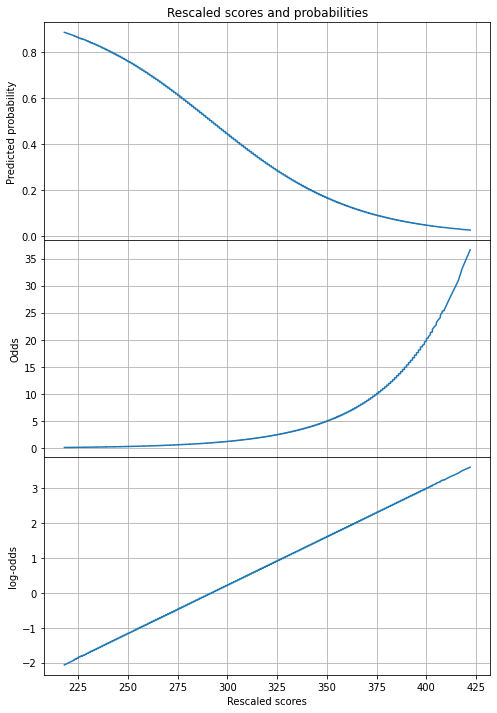

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8,12), gridspec_kw={'hspace': 0})
ax1.plot( scores.values, proba_train.values)

ax1.set_ylabel("Predicted probability")
ax1.set_title("Rescaled scores and probabilities")
ax1.grid()


ax2.plot(scores.values, proba_train.apply(lambda x: (1-x)/x).values )
ax2.set_ylabel("Odds")
ax2.grid()


ax3.plot(scores.values, proba_train.apply(lambda x: np.log(1-x) - np.log(x)).values,)
ax3.set_ylabel("log-odds")
ax3.grid()
ax3.set_xlabel("Rescaled scores")

plt.show()


# Assigning points to every feature

The last step of a scorecard development is to convert all the features into the rescaled model.<br>

A scorecard model is a logisitic regression fitted on the WoE values of every single bucketed feature.<br>
In other words, the following equations holds:

$$ log(odds) = log(\frac{1-p}{p}) = \beta_{0} + \sum_{i} \beta_{i} \cdot WOE(X_{i}) $$

As the rescaling performed earlier is linear in the predicted `log-odds`, this means that the every feature-bucket contribution can be rescaled to an integer value (by rescaling directly the $ \beta_{i} \cdot WOE(X_{i})$ factors with the same calculations. <br>

This returns the final scorecard, that can be easily implemented.<br>

The functionality in `skorecard` to rescale the features is as follows

In [11]:
from skorecard.rescale import ScoreCardPoints
# ensure that pdo, ref_score and ref_odds are consistent
scp = ScoreCardPoints(skorecard_model=scorecard,  pdo = 25, ref_score = 400, ref_odds = 20) 


one can extract the final scorecard as follows

In [12]:
scp.get_scorecard_points()

,bin_index,map,woe,feature,coef,contribution,Points
1,0,"[-inf, -0.5)",0.419571,x6,-0.764208,-0.320639,49
2,1,"[-0.5, 0.5)",0.668214,x6,-0.764208,-0.510655,56
3,2,"[0.5, 1.5)",-0.585414,x6,-0.764208,0.447378,21
4,3,"[1.5, inf)",-2.094401,x6,-0.764208,1.600558,-20
6,0,"[-inf, 1.5)",0.321072,x8,-0.269190,-0.086429,41
7,1,"[1.5, inf)",-1.392144,x8,-0.269190,0.374751,24
9,0,"[-inf, 1.0)",0.229952,x10,-0.339152,-0.077989,40
10,1,"[1.0, inf)",-1.490744,x10,-0.339152,0.505589,19
12,0,"[-inf, 21.0)",-0.691658,x18,-0.241746,0.167205,31
13,1,"[21.0, 4552.5)",0.029155,x18,-0.241746,-0.007048,38


Or one can apply the transformation directly on the data, by calling the `transform` method, in order to map each feature to its actual points.

#### Validate the rescaling

As the last step, in order to ensure that the rescaling was successfull, one can verify that the sum of the points of each row in the dataset matches the rescaled scores.<br>
The rescaling steps has some integer rounding, therefore small discrepancies of 1-2 points might occur due to the rounding error

In [13]:
proba_train = pd.Series(proba_train, index = y_train.index) #convert to pandas and correct index in order to be able to perform the diff
scores = calibrate_to_master_scale(proba_train, pdo = 25, ref_score = 400, ref_odds = 20)

# Check the distribution of the differences
(scores - scp.transform(X_train).sum(axis=1)).value_counts()

-1    10816
 0     7892
 1     1994
-2     1716
 2       82
dtype: int64